In [1]:
from helpers import *

In [2]:
%matplotlib inline 

In [6]:
run_pipeline(276)

Using most common size (256, 192). Remaining 13 images.
Using min length 30.
80.0


(161.34742356958498, 309.10912227844409)

In [14]:
for case in range(123, 124):
    patient, meta = all_slices(case, pix=True)
    # get layer meta data
    pix_spacing = np.array([m['PixelSpacing'] for m in meta])
    heights = get_heights_from_meta(meta)
    # get middle
    num_layers, num_times = np.shape(patient)[0:2]
    mid_layer = num_layers//2
    ############### start get region of interest ##################
    for iteration in range(BBOX_ITERS):
        mid_slice = patient[mid_layer]
        mid_slice_stfd = spatial_temporal_finite_difference(mid_slice)
        mid_slice_stfd = threshold_std(mid_slice_stfd)
        # blur
        result = ndimage.gaussian_filter(mid_slice_stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD)
        # get centroid
        row,col = get_centroid(result)
        # get roi
        rstart, rend, cstart, cend = bounding_square(result, row, col)
        # crop patient
        patient = map(lambda sl: map(lambda x: x[rstart:rend, cstart:cend], sl), patient)
    ############### end get region of interest ##################
    ## GET EXPECTED SIZE AS PROP OF ROI ##
    max_size_pix = 1000.*MAX_ML/(heights.min()*pix_spacing.min())
    roi_size_pix = ((rend-rstart)*(cend-cstart))
    lv_fraction = 1.*max_size_pix/roi_size_pix
    frac_to_remove = min(.75, 1.-lv_fraction)*100
    ## END GET EXPECTED SIZE AS PROP OF ROI ##
    ############### start prop through space and time ##################
    # initialize tracks array
    shape = np.shape(patient)
    tracks = np.zeros(shape)
    priors = np.zeros(shape)
    posts = np.zeros(shape)
    masks = np.zeros(shape)
    # compute mid_layer prior and prop through time
    mid_layer_stfd = spatial_temporal_finite_difference(patient[mid_layer])
    prior = ndimage.gaussian_filter(mid_layer_stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD**2) #TODO: update this

    masks[mid_layer] = get_slice_components(patient[mid_layer], perc=frac_to_remove)
    priors[mid_layer], posts[mid_layer], tracks[mid_layer] = \
        zip(*prop_through_time(masks[mid_layer], prior=prior, end_t=num_times))
    # prop down
    for curr in range(mid_layer+1,num_layers):
        prev = curr - 1
        prior = calculate_layer_prior(tracks, prev=prev)
        masks[curr] = get_slice_components(patient[curr], perc=frac_to_remove)
        priors[curr], posts[curr], tracks[curr] = \
            zip(*prop_through_time(masks[curr], prior=prior, end_t=num_times))
    # prop up
    for curr in range(mid_layer)[::-1]: # mid_layer-1, mid_layer-2
        prev = curr + 1
        prior = calculate_layer_prior(tracks, prev=prev)
        masks[curr] = get_slice_components(patient[curr], perc=frac_to_remove)
        priors[curr], posts[curr], tracks[curr] = \
            zip(*prop_through_time(masks[curr], prior=prior, end_t=num_times))
    ############### end prop through space and time ##################
    volume = get_volume_from_track(tracks, pix_spacing, heights)

Using min length 30.



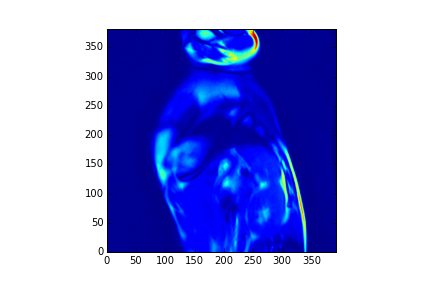
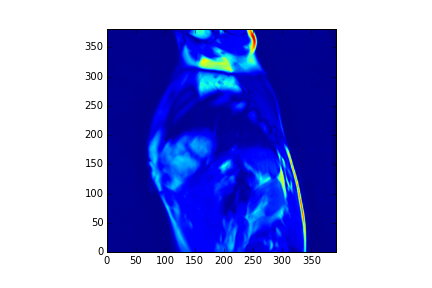
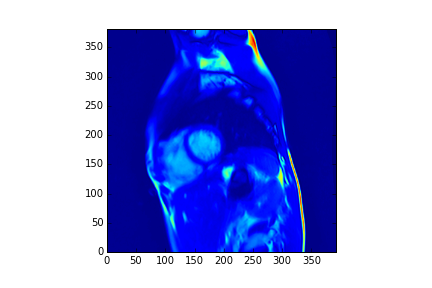
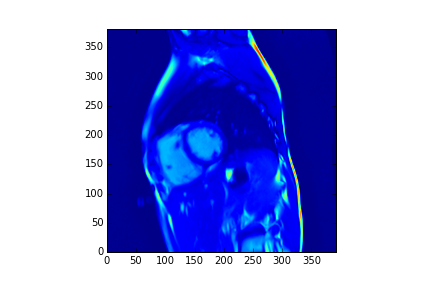
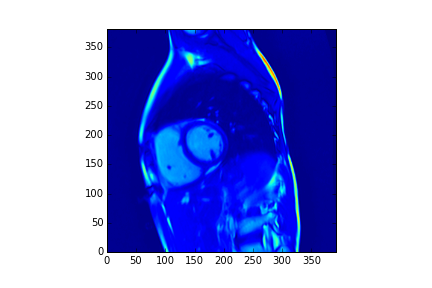
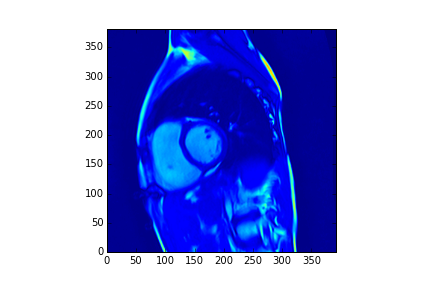
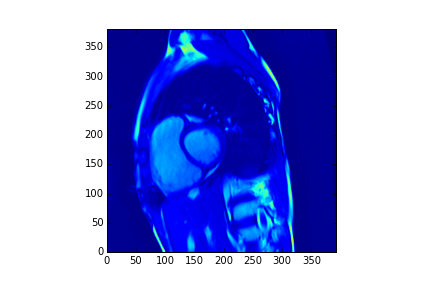
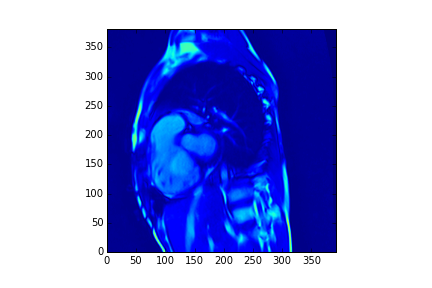
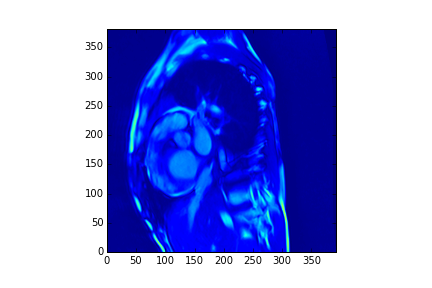
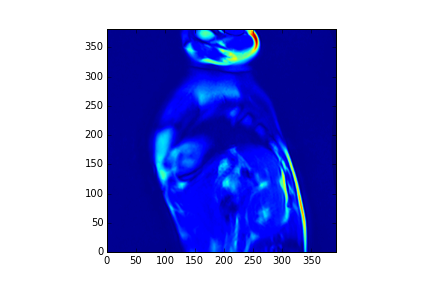
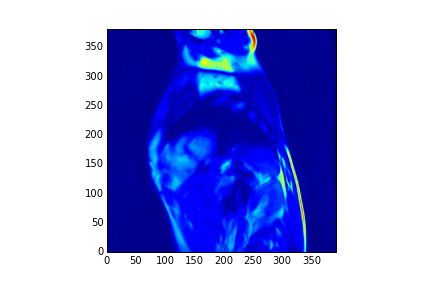
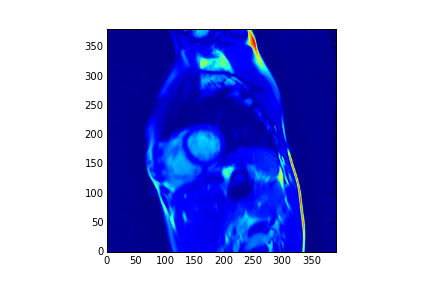
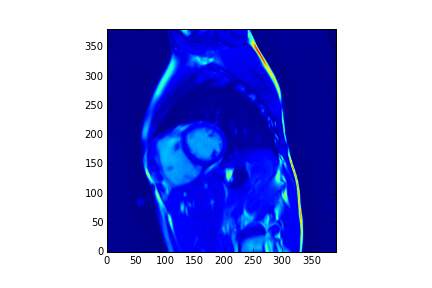
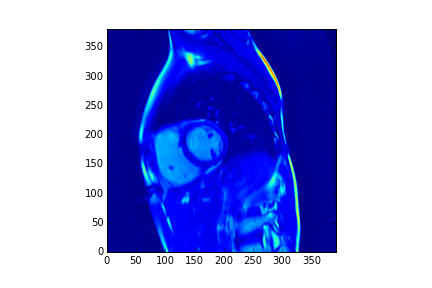
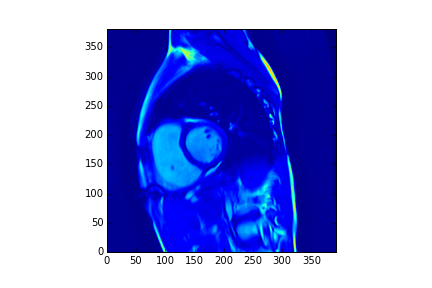
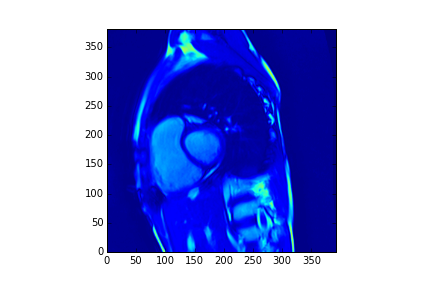
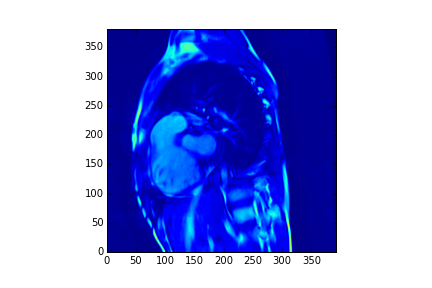
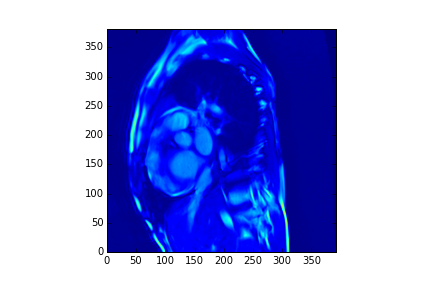
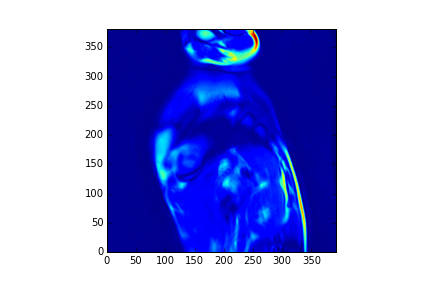
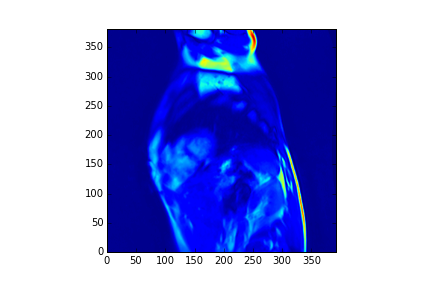
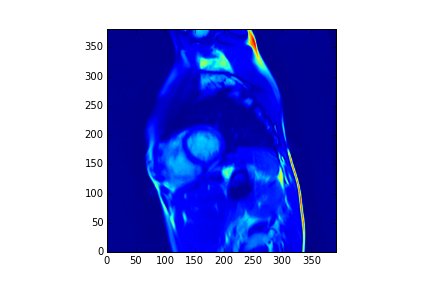
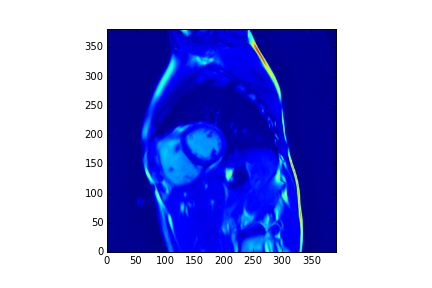
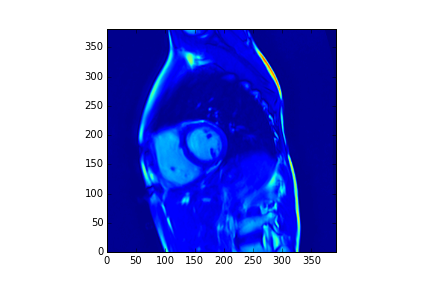
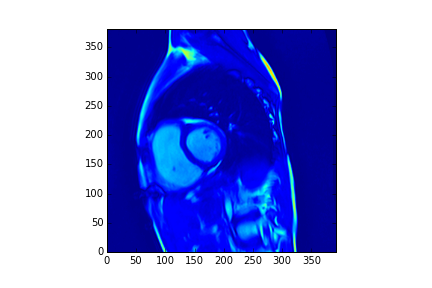
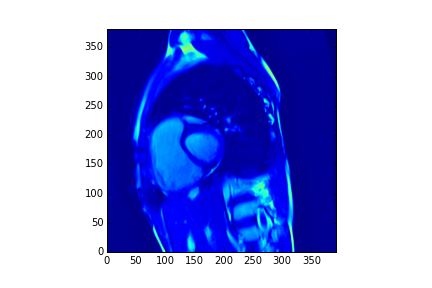
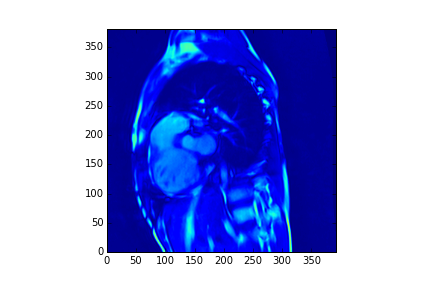
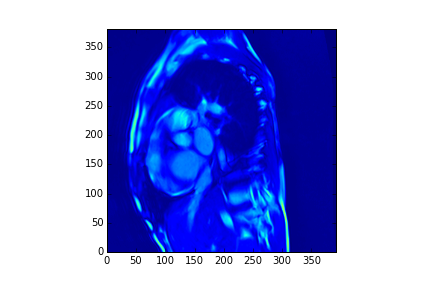
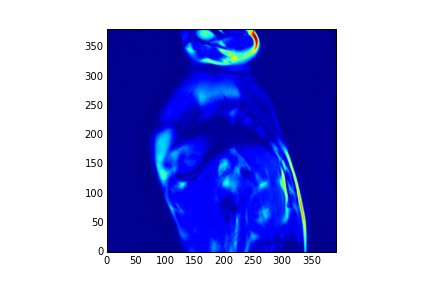
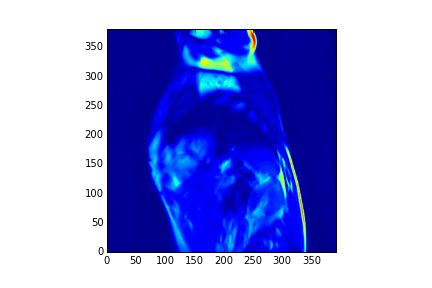
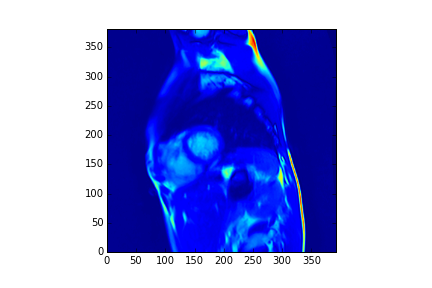

In [37]:
animate(patient[1], None)

#  Step-by-Step Through the Pipeline

Using most common size (256, 230). Remaining 16 images.
Using min length 30.


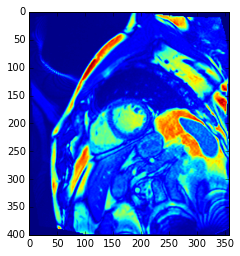

In [3]:
case = 1
patient, meta = all_slices(case, pix=True)
#Get the middle slice
num_layers = len(patient)
mid_layer = num_layers//2
mid_slice = patient[mid_layer]
#Resize image so that each pixel=1mmx1mm
px = np.sqrt(meta[0]['PixelSpacing'])
width = int(px*mid_slice[0].shape[0])
height = int(px*mid_slice[0].shape[1])

resized_image = scipy.misc.imresize(mid_slice[0], (width,height))
plt.imshow(resized_image)

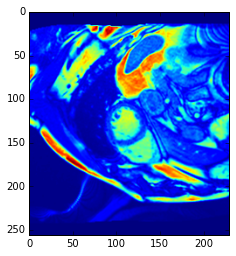

In [10]:
rotated_image = scipy.misc.imrotate(mid_slice[0], 90)
plt.imshow(rotated_image)

In [3]:
def bounding_square(result, row, col, incs=2, prop=.85):
    rsize, csize = result.shape
    width = 64
    condition = True
    result = result.astype(float)
    total = result.sum()
    #while condition:

    #   cand = result[max(0,row-width):min(row+width,rsize-1),
    #                  max(0,col-width):min(col+width, csize-1)].sum()/float(total)
    #    condition = (cand < prop) || width == 64

     #   width += incs
    return (max(0,row-width),min(row+width,rsize-1) ,
                max(0,col-width), min(col+width, csize-1))

Using most common size (256, 230). Remaining 16 images.
Using min length 30.


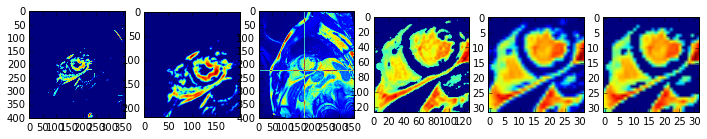

In [12]:
broken = []
mid_layer = 5
for case in range(1,2):
    try:
        if case % 20 == 0:
            print case
        patient, meta = all_slices(case, pix=True)
        #Get the middle slice
        num_layers = len(patient)
        mid_slice = patient[mid_layer]
        #Resize image so that each pixel=1mmx1mm
        px = np.sqrt(meta[0]['PixelSpacing'])
        height = int(px*mid_slice[0].shape[0])
        width = int(px*mid_slice[0].shape[1])
        resized_image = scipy.misc.imresize(mid_slice[0], (height,width))
        #####################################################################
        mid_slice_stfd = spatial_temporal_finite_difference(mid_slice)
        mid_slice_stfd = threshold_std(mid_slice_stfd,2.)
        resized_stfd = scipy.misc.imresize(mid_slice_stfd, (height,width))
        if width > height:
            resized_image = resized_image.T[::-1,:]
            resized_stfd = resized_stfd.T[::-1,:]
            t = width
            width = height
            height = t
        #Do some cropping
        cropped_resized_image = resized_image[int(0.2*height):int(-0.25*height),int(0.15*width):int(-0.3*width)]
        cropped_resized_stfd = resized_stfd[int(0.2*height):int(-0.25*height),int(0.15*width):int(-0.3*width)]
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1,6,1)
        plt.imshow(resized_stfd)
        #####################################################################
        plt.subplot(1,6,2)
        result = ndimage.gaussian_filter(cropped_resized_stfd, 1)
        plt.imshow(result)
        row,col = get_centroid(result)
        row += int(0.2*height)
        col += int(0.15*width)
        center = line_mask(resized_image, row, col)
        plt.subplot(1,6,3)
        plt.imshow(center + resized_image)
        # crop patient
        width = 64
        rsize, csize = resized_image.shape
        top, bottom = max(0,row-width),min(row+width,rsize-1)
        left, right = max(0,col-width), min(col+width, csize-1)
        #Correct Heights
        height_diff = bottom - top
        if height_diff < width:
            if top == 0:
                bottom += height_diff
            if bottom == rsize-1:
                top -= height_diff
        #Correct Widths
        width_diff = right - left
        if height_diff < width:
            if left == 0:
                right += width_diff
            if right == csize-1:
                left -= width_diff
        resized_image = resized_image[top:bottom, left:right]
        resized_image *= (resized_image > np.percentile(resized_image, 50))
        plt.subplot(1,6,4)
        plt.imshow(resized_image)
        plt.subplot(1,6,5)
        small_img = scipy.misc.imresize(resized_image, (32,32))
        plt.imshow(small_img)
        plt.subplot(1,6,6)
        #plt.imshow(small_img*(small_img > np.percentile(small_img, 50)))
        #plt.savefig(str(case))
        #plt.close(fig)
    except:
        broken.append(case)

In [18]:
(small_img.astype(float)/small_img.max()).std()

0.31061268132878228

In [14]:
broken

[]

# Phase 0 - Load a patient

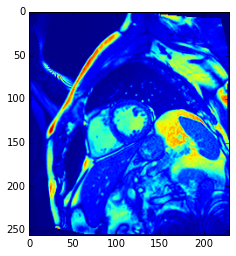

In [66]:
case = 1
patient, meta = all_slices(case, pix=True)
#Get the middle slice
num_layers = len(patient)
mid_layer = num_layers//2
mid_slice = patient[mid_layer]

plt.imshow(mid_slice[0])

# Phase 1 - Data Cleanup

## 1.1 - Fixing High Contrast

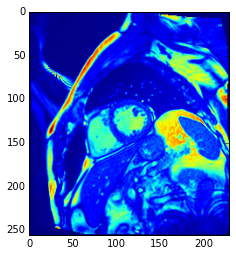

In [5]:
patient = fix_contrast(np.array(patient))
mid_slice = patient[mid_layer]

plt.imshow(mid_slice[0])

## 1.2 - Find the area that changes most

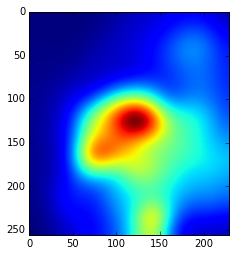

In [69]:
mid_slice_stfd = spatial_temporal_finite_difference(mid_slice)
plt.imshow(ndimage.gaussian_filter(mid_slice_stfd, 15))

### 1.2.2 - Threshold at a value to cleanup a bit more

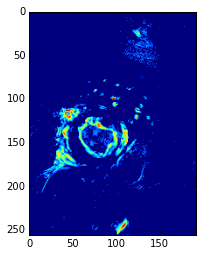

In [5]:
mid_slice_stfd = threshold_std(mid_slice_stfd,1.)

plt.imshow(mid_slice_stfd)

## 1.3 - Get the centroid of this region

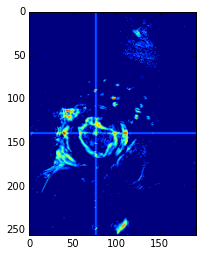

In [6]:
# blur
result = cv2.GaussianBlur(mid_slice_stfd, (9, 9), 0)
# get centroid
row,col = get_centroid(result)
center = line_mask(result, row, col)
plt.imshow(center+mid_slice_stfd)

## 1.4 - Find a good bounding square around the centroid to reduce the size of the image to a smaller ROI

Size reduction: 0.533935546875


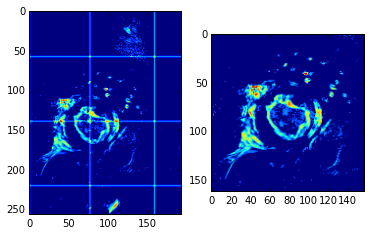

In [7]:
# get roi
rstart, rend, cstart, cend = bounding_square(result, row, col)
width = rend-rstart

mid_slice = map(lambda x: x[rstart:rend, cstart:cend], mid_slice)
old_mid_slice_stfd = mid_slice_stfd.copy()
mid_slice_stfd = mid_slice_stfd[rstart:rend,cstart:cend]

print 'Size reduction:', ((rend-rstart)**2)/float(result.size)
rlm = line_mask(result, rstart, cstart)
clm = line_mask(result, rend, cend)
center = line_mask(result, row, col)
plt.subplot(1,2,1)
plt.imshow(rlm+ clm+center+old_mid_slice_stfd)
plt.subplot(1,2,2)
plt.imshow(mid_slice_stfd)

## Experiment downsampling the bounding box image

In [124]:
#case = 3
MAX_ITER = 7
broken = []
for case in range(25, 101):
    try:
        patient, meta = all_slices(case, pix=True)
        # get layer meta data
        pix_spacing = np.array([m['PixelSpacing'] for m in meta])
        heights = get_heights_from_meta(meta)
        # get middle
        num_layers, num_times = np.shape(patient)[0:2]
        mid_layer = num_layers//2
        ############### start get region of interest ##################
        for iteration in range(MAX_ITER):
            mid_slice = patient[mid_layer]
            mid_slice_stfd = spatial_temporal_finite_difference(mid_slice)
            mid_slice_stfd = threshold_std(mid_slice_stfd)
            # blur
            result = ndimage.gaussian_filter(mid_slice_stfd, 20)
            #result = ndimage.gaussian_filter(mid_slice_stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD)
            # get centroid
            #row,col = get_centroid(result)
            pixel = np.argmax(result)#get_centroid(result)
            row,col = pixel/result.shape[1], pixel%result.shape[1]
            # get roi
            #rstart, rend, cstart, cend = bounding_square(result, row, col)
            rstart, rend, cstart, cend = bounding_square(mid_slice_stfd, row, col)
            reduction = ((rend-rstart)**2)/float(result.size)
            #print 'Size reduction:', reduction
            # crop patient
            patient = map(lambda sl: map(lambda x: x[rstart:rend, cstart:cend], sl), patient)
            if reduction > 0.96:
                break
        plt.imsave(str(case),mid_slice[0])
    except:
        broken.append(case)
    #scipy.misc.imresize(mid_slice[0], (30,30))
    #animate([scipy.misc.imresize(m, (30,30)) for i,m in enumerate(mid_slice) if i%3==0], None)

In [52]:
broken

[41, 83]

# Phase 2 - Segmentation

## 2.1 - Get most significant connected components for the mid-slice over each time-frame

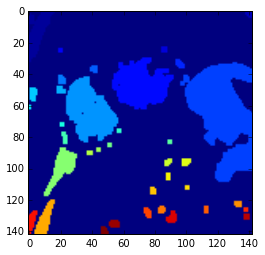

In [10]:
# get slice components
components = map(lambda i: filtered_components(mid_slice[i]), range(30))
#Unpack the components tuple
masks,areas,centroids = map(np.array, zip(*components))
plt.imshow(components[0][0])

# 2.1.1 - Propagate components through time

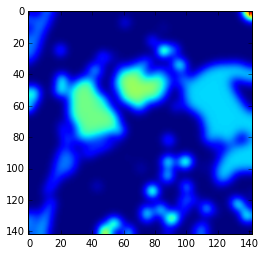

In [11]:
end_t = 30
time_weights = ((np.cos(np.arange(end_t)/5.)+1.1)/2.)[:,None,None]
time_priors = map(weighted_probability_mask, masks[:end_t])


modes = np.exp(np.sum(time_weights*time_priors, 0)) # product behaved badly
modes /= modes.max()
plt.imshow(modes)


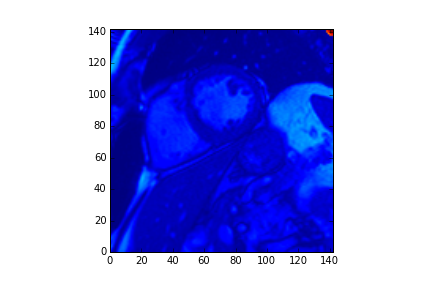
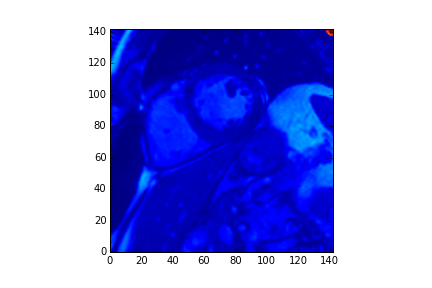
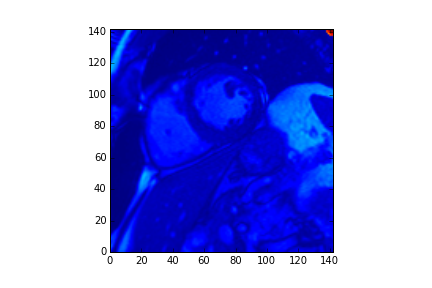
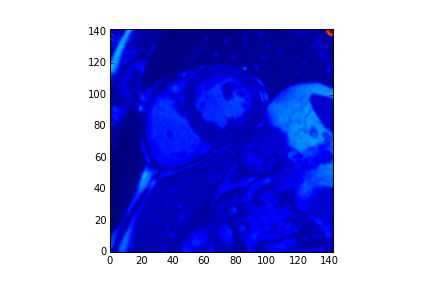
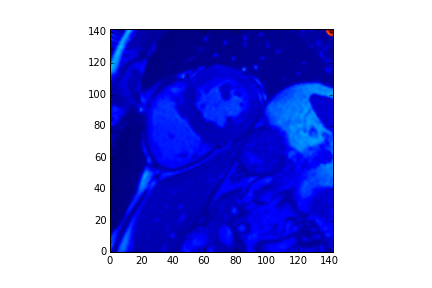
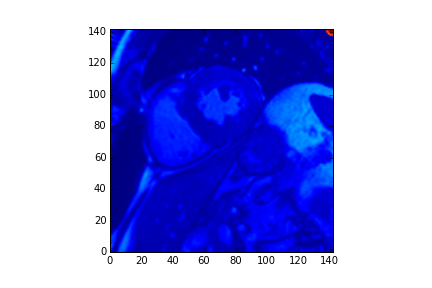
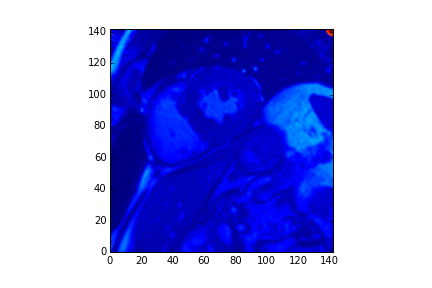
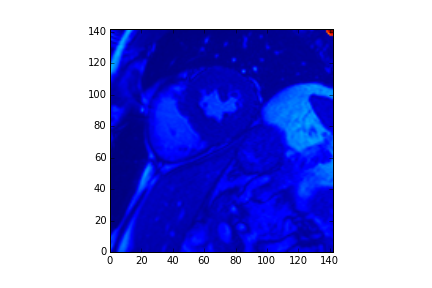
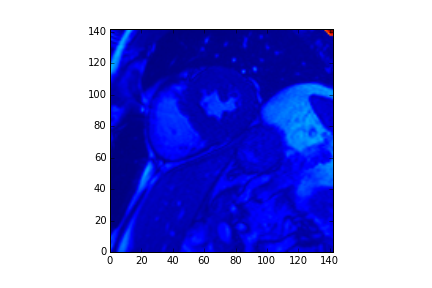
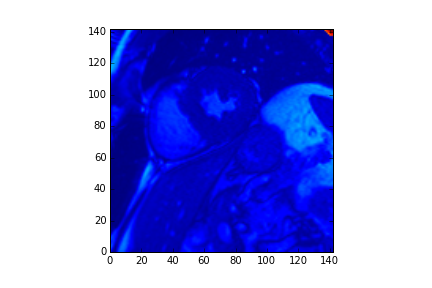
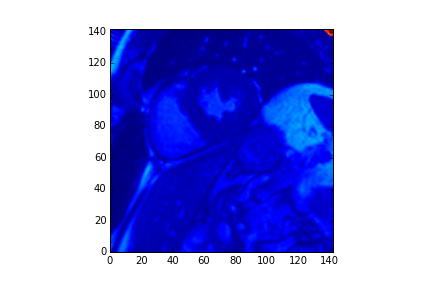
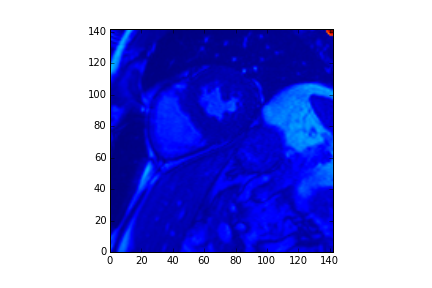
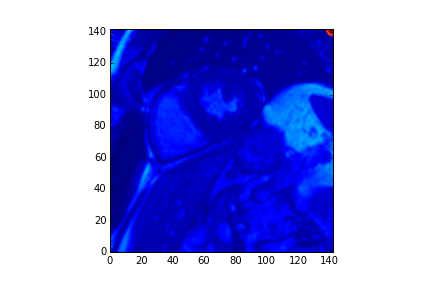
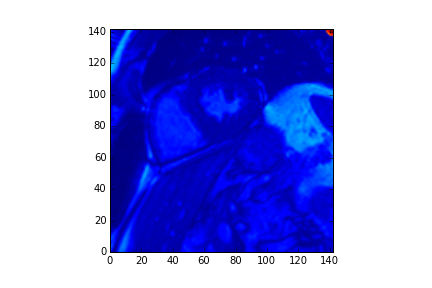
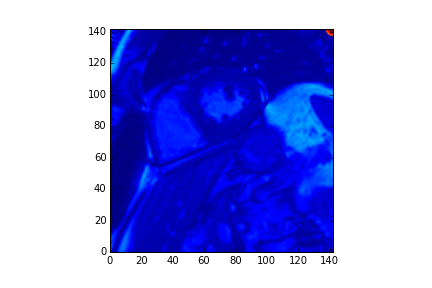
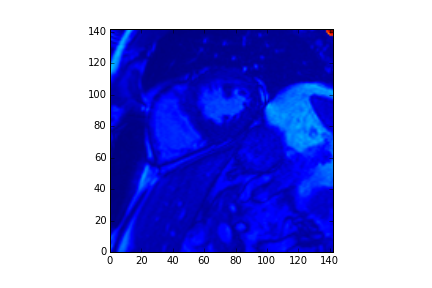
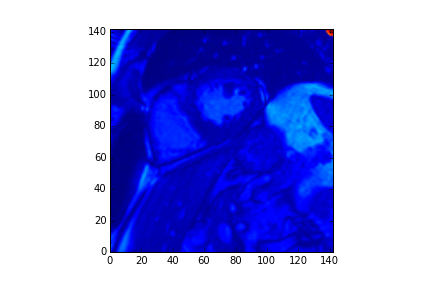
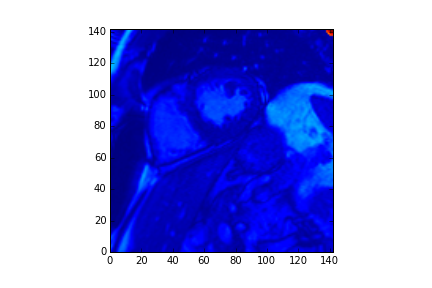
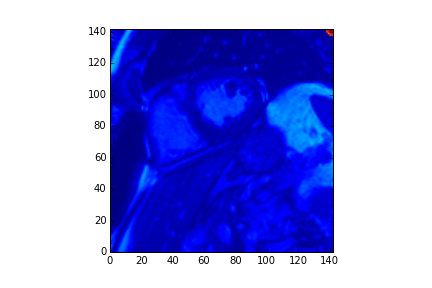
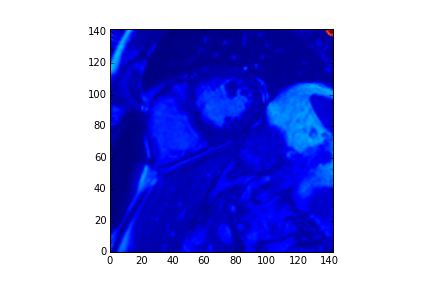
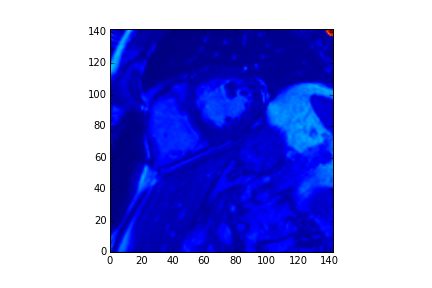
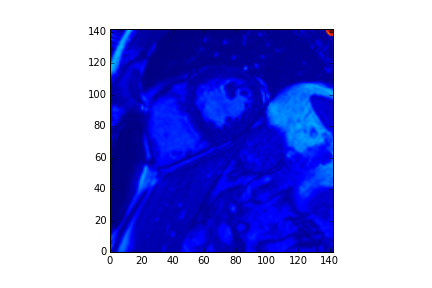
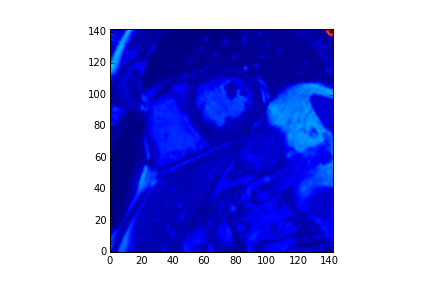
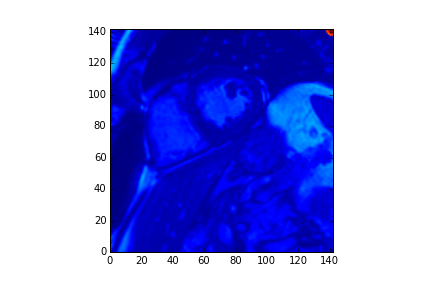
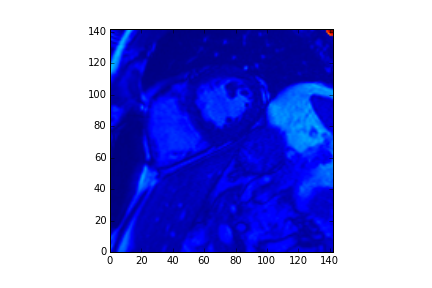
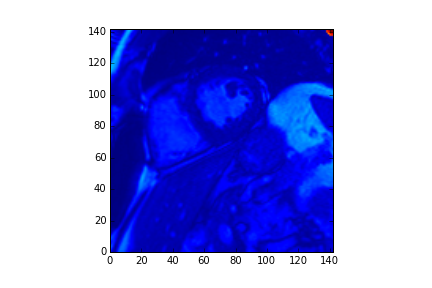
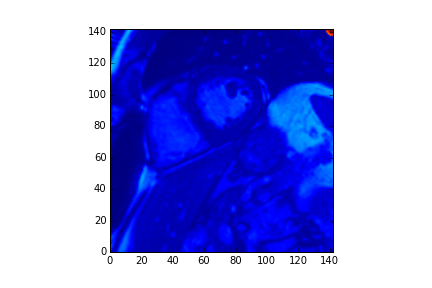
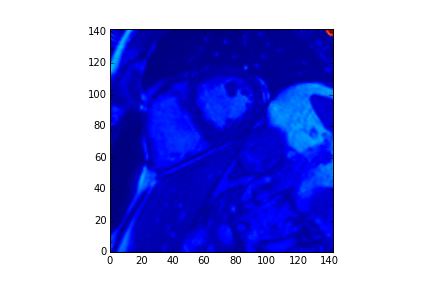
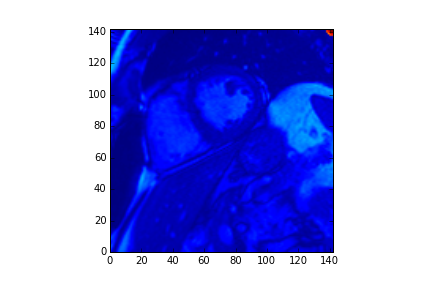
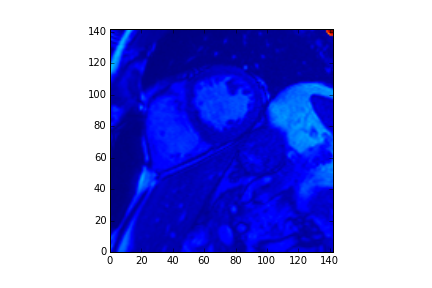

In [13]:
animate(map(lambda x: get_lv(modes, masks, x)*1000.+mid_slice[x], range(30)), None)

In [ ]:
plt.plot(map(np.sum, map(get_lv, range(30))))

## 2.2 - Track each of the connected components over time to match components over the time frames

In [ ]:
# match components over time
tracks = track_objects(masks)
# throw away background mask
# toss_away = np.nonzero(0==tracks[:,:-1].sum(1))[0][0]
# tracks = np.delete(tracks, toss_away, axis=0)

## 2.3 - Plot the area curves of the primary connected components over time after matching them. Based on these curves, we should have a better idea of which connected component is more likely to be the left ventricle

In [ ]:
rareas = np.zeros_like(tracks)
for i in range(30):
    rareas[:,i] = areas[i][tracks[:,i].astype(int)-1]

rareas = rareas.T[:-1,:]
plt.plot(rareas)

## (Option 1) 2.4 - Combine the graphs weighted by an estimate of their likelihoods. Currently we're using the ejection fraction of each area curve and comparing it to the training set's statistics, assuming that EFs are normally distributed

In [ ]:
mean_ef, std_ef = get_training_statistics()
plt.plot(weight_by_prob(rareas, mean_ef, std_ef))

## (Option 2) 2.4 - Decide which one is the LV. Currently using frequency response at harmonics 1, 2 and 3

In [ ]:
best = best_harmonic_fit(rareas.T)
plt.plot(rareas[:,best])

## 2.5 - Enforce temporal consistency by propagating the LV mask for a particular slice through time

## 2.6 - Enforce spatial consistency by propagating the LV mask of the mid-slice up and down the other slices at the same time

# Phase 3 - Compute the volumes for each time frame

In [269]:
case = 4
patient, meta = all_slices(case, pix=True)

# fix contrast
patient = fix_contrast(np.array(patient))

# get middle
num_layers, num_time = np.shape(patient)[0:2]
mid_layer = num_layers//2

# get region of interest
patient = get_roi(patient)

# get new stfd
mid_layer_stfd = spatial_temporal_finite_difference(patient[mid_layer])
prior = ndimage.gaussian_filter(mid_layer_stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD**2) #TODO: update this

# get tracks
track = np.zeros_like(patient)
# do middle layer
prop_through_space(track, patient, mid_layer, 0, prior=prior)
#animate([300*track[mid_layer][i]+patient[mid_layer][i] for i in range(30)], None)
# prop up
for i in range(1,mid_layer+1):
    prop_through_space(track, patient, mid_layer, i)
# prop down
for i in range(1,num_layers-mid_layer):
    prop_through_space(track, patient, mid_layer, -i)
    
track = track[2:-2]
meta = meta[2:-2]

# sum over pixels (still have (num_layers, num_times) array)
a = track.sum(2).sum(2)
num_times = track.shape[1]
a_interp = linear_interpolate(a, num_times)

# multiply each layer by its pixel size to get mm^2
#area_mults = np.array([m['PixelSpacing'] for m in meta])
#areas = area_mults[:,None] * a_interp

# multiply each area by its height to get mm^3
#heights = np.array([m['SliceThickness'] for m in meta])
#volumes = heights[:,None]*areas
#volume = get_volume_from_track(track, meta)
#plt.plot(volume)

In [267]:
def spatial_temporal_interpolation(curve, reference, thresh=0.5):
    '''Interpolates points in curve using reference to fill in blanks. Thresh is the gradient threshold at 
        which a point is dropped'''
    curve = curve.astype(float)
    grads = np.array([abs(curve[i+1]/curve[i]) for i in range(len(curve)-1)]) #np.abs(np.gradient(curve))
    old_grads = grads
    while (grads > thresh).sum() > 0:
        for i in range(len(curve)-1):
            if grads[i] > (1+thresh) or grads[i] < (1-thresh):
                curve[i+1] = 0.5*reference[i+1] + 0.5*curve[i] #Interpolate with average in time and space
        #grad = np.abs(np.gradient(curve))
        grads = np.array([abs(curve[i+1]/curve[i]) for i in range(len(curve)-1)])
        if (grads == old_grads).all():
            break
        else:
            old_grads = grads
    return curve

In [268]:
def interpolate_matrix(areas, thresh=0.5):
    '''Takes a patient area/volume matrix and tries to smooth it out by removing big spikes'''
    #interpolate above the mid_slice
    mid_slice = areas.shape[0]//2
    for i in range(mid_slice-1,-1,-1):
        new = spatial_temporal_interpolation(areas[i], areas[i+1], thresh=thresh)
        areas[i] = new
    for i in range(mid_slice+1, areas.shape[0]):
        new = spatial_temporal_interpolation(areas[i], areas[i-1], thresh=thresh)
        areas[i] = new
    return areas